<a href="https://colab.research.google.com/github/michaelbarkasi/computational_neuroscience/blob/main/GLM_of_task_dependent_correlation_faux_data_simulation_NMA_2023_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2023 HCP Group Project: GLM of task-dependent correlation

Michael Barkasi 2023

## Abstract

It’s been observed in the literature that functional connectivity (FC) between brain regions varies between rest state and task-based activity. These observations include some evidence that task-based FC in the somatomotor network depends on extremity and lateral factors. We explore the details of these extremity-lateral factors, using fMRI data from the Human Connectome Project (HCP). Does task-based FC in somatomotor cortex depend on lateral (left vs right) and extremity (hand vs foot) location? To answer this question, we first considered measures of FC. In the literature, there’s no standard such measure. We used and compared two different ones: Pearson correlation and phase synchrony. We expected these measures to coincide. With measures of FC in hand, we built models which predict FC between two regions R1 and R2 over time, dependent on: (1) BOLD activity of R1 and R2, (2) lateral position of current task, and (3) extremity position of current task. The basic idea is that if task-based FC in somatomotor cortex (for the modeled regions R1 and R2) depends on lateral and extremity location, then the fit of the model will depend on including these factors. If instead a model without variables for extremity and lateral task position fits the data just as well, then we can conclude that extremity and lateral task position do not matter. We compared simple linear models (GLMs) with dynamical models. These dynamical models capture the underlying nonlinearity of the brain and test task-based FC by modeling the FC as the phase synchronization of two coupled neural oscillators, dependent on lateral and extremity task position. We expected that the nonlinear modeling would provide a better fit for the data and would provide greater insight into the instantaneous dynamics.

## Note

As this CoLab would suggest, I did the GLM modelling (which appears here). As can be seen by running the code and trying things out, we weren't able to model Pearson correlation (over a moving window on the time-series), but we were able show that a GLM of one region's activity does best when given both another region's activity and extremity and laterality information as input (vs just the other region's activity, or just the extremity and laterality information).

The NMA group project used data from the Human Connectome Project. This version of the code first generates simulated faux fMRI data of somatomotor cortex.

## About this CoLab

This CoLab first generates some faux sample fMRI data of somatomotor cortex during unilateral hand, unilateral foot, and tongue movements, then uses a GLM to model one region's activity as a function of another region's activity, plus information about the laterality and extremity of the motor task being performed. It shows that the GLM does best when given all inputs, vs being given only another region's activity or only the extremity and laterality input.

The GLM was originally written to be used with the curated [Human Connectome Project data released by Neuromatch Academy](https://compneuro.neuromatch.io/projects/fMRI/README.html). It works pretty well with real data, but the HCP data has limitations on sharing, so for this demo I just use simulated data. The simulated data is at the region level (Brodmann regions, specifically).

It turns out that simulating fMRI data in any way that's even sort of realistic is tricky. My simulated data has some biologically realistic features, but is unrealistic in many ways as well.

Although the data used here is all simulated, the region names are based on the atlas by [Glasser et al. 2016](https://www.nature.com/articles/nature18933), described [in the paper's supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf). Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

A few chunks of code are borrowed from the [2023 NMA material](https://compneuro.neuromatch.io/tutorials/intro.html), but mostly everything here is mine. The code for the band-pass filter was suggested to me by ChatGPT. I double checked it and tweaked it. I used ChatGPT for other suggestions here or there, but nothing else substantive.

[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/) // [BSD (3-Clause) License](https://opensource.org/licenses/BSD-3-Clause)

In [2]:
# @title CoLab Reset
# Want to reset loaded code?
%reset -f

In [14]:
# @title Helper Functions

def HRF(t,A):
  '''
  Hemodynamic Response Function (cannonical double gamma)
  t = time
  A = reponse amplitude
  from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3318970/#FD7
  '''
  a1 = 6
  a2 = 16
  b1 = 1
  b2 = 1
  c = 1/6
  term1 = ((t**(a1-1))*(b1**a1)*(np.exp(-b1*t)))/scipy.special.gamma(a1)
  term2 = ((t**(a2-1))*(b2**a2)*(np.exp(-b2*t)))/scipy.special.gamma(a2)
  output = A * (term1 - c*term2)
  return output

def convolve_HRF(time_series,conv_window,amplitude):
  '''
  Convolve time_series with HRF (hemodynamic response function)
  time_series = time series to be convolved
  conv_window = window for convolving
  amplitude = amplitude of HRF
  '''
  conv_time_series = np.zeros(len(time_series))
  for series_time in np.arange(len(time_series)):
      conv_time_series[series_time] = np.sum(time_series[series_time-np.arange(conv_window)] * HRF(np.arange(conv_window),amplitude))

  return conv_time_series

def stim_frames(data,subj_,run_,cond):
  cond_ = 0
  if type(cond) == str:
    cond_ = np.where(tasks == cond)[0]
  else:
    cond_ = cond
  time_series_ = data[:,cond_,subj_,run_]
  return np.where(time_series_ == 1)[0]

def region_index(region__):
  reg_ = 0
  if type(region__) == str:
    keys_list = list(somatomotor_regions.keys())
    reg_ = keys_list.index(region__)
  else:
    reg_ = region__
  return reg_

def band_pass(x,sampling_frequency=1.389,lower_cutoff_frequency=0.008,upper_cutoff_frequency=0.09):

  '''
  for the default values, 1.389 = 1 sec / 0.72 sec sample interval,
  and 0.008 / 0.09 are standard cutoffs for fMRI data.
  '''

  # Perform Fourier transform
  x_freq = np.fft.fft(x)

  # Apply band-pass filter in frequency domain
  n = len(x)
  frequencies = np.fft.fftfreq(n, d=1/sampling_frequency)
  # x_freq[np.abs(frequencies) > cutoff_frequency] = 0 # if using just as a low-pass
  x_freq[np.logical_or(frequencies < lower_cutoff_frequency, frequencies > upper_cutoff_frequency)] = 0

  # Perform inverse Fourier transform
  x_filtered = np.fft.ifft(x_freq).real

  return x_filtered

def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """

  y_pred = model.predict(X)
  accuracy = (y == y_pred).mean()
  ones = np.where(y)[0]
  pos_accuracy = (y[ones] == y_pred[ones]).mean()
  zeros = np.where(y==0)[0]
  neg_accuracy = (y[zeros] == y_pred[zeros]).mean()

  return accuracy,pos_accuracy,neg_accuracy

def make_inputs(remove_EL__,remove_last_corr__,remove_intercept__,remove_activity__):
  inputs__ = np.arange(5)
  input_variable_list__ = ['intercept','r1_activity','r2_activity','extremity','lateral','last_corr']
  if remove_EL__:
    inputs__ = np.array([0,1,4])
    input_variable_list__ = ['intercept','r1_activity','r2_activity','last_corr']
  if not predict_corr and remove_EL__:
    inputs__ = np.array([1,4])
    input_variable_list__ = ['intercept','r2_activity','last_corr']
  elif not predict_corr:
    inputs__ = np.array([1,2,3,4])
    input_variable_list__ = ['intercept','r2_activity','extremity','lateral','last_corr']
  if remove_last_corr__:
    inputs__ = inputs__[:(len(inputs__)-1)]
    input_variable_list__ = input_variable_list__[:(len(input_variable_list__)-1)]
  if remove_intercept__:
    input_variable_list__ = input_variable_list__[1:]
  if remove_activity__ and predict_corr:
    r1i__ = np.where(np.array(input_variable_list__) == 'r1_activity')[0][0]
    input_variable_list__ = np.delete(input_variable_list__, r1i__)
    if r1i__ > 0:
      inputs__ = np.delete(inputs__, r1i__ - 1)
    r2i__ = np.where(np.array(input_variable_list__) == 'r2_activity')[0][0]
    input_variable_list__ = np.delete(input_variable_list__, r2i__)
    if r2i__ > 0:
      inputs__ = np.delete(inputs__, r2i__ - 1)
  elif remove_activity__:
    r2i__ = np.where(np.array(input_variable_list__) == 'r2_activity')[0][0]
    input_variable_list__ = np.delete(input_variable_list__, r2i__)
    if r2i__ > 0:
      inputs__ = np.delete(inputs__, r2i__ - 1)

  return inputs__, input_variable_list__

# Simulate Data

This simulation procedure was written for a [logistic regression decoder](https://github.com/michaelbarkasi/computational_neuroscience/blob/256dd4e68d56b6aed001d6768e3ee735f270f29b/neural_decoding_template_faux_data_simulation.ipynb), but also with the idea in mind that it should force some interesting task-dependent correlationals for the GLM of this project to find. With the decoder in mind, when writing this simulation, my aim was to:

1. Inject information into the simulated BOLD activity level about what simulated task was happening, without
2. making it trivially easy to decode.

There are a few layers to the simulated BOLD activity:

1. A base level of noise and upward drift (often seen in real fMRI data).
2. A level of random noise in the form of what I call "random-walk mind wandering". Basically, Basically, suppose the subject isn't really focused and is doing other things (thinking, moving) in ways that cause the BOLD level to shift in the form of a random walk.
3. The task-depenent BOLD response itself.

The last of these is, of course, what the logistic regression decoder tries to pull out of the data, and task-dependent correlations between this signal in different regions is what this GLM is designed to find.
The exact method used here to simulate the BOLD response has several layers, but the gist is a two step process:

1. Pick, for each region, a response amplitude for each task. The larger the magnetude of this response, the more the region becomes a "detector" for that task.
2. For each subject, randomly jitter this response amplitude.

The second step is needed, otherwise the detector sits at 100% accuracy under all but the most extreme noise conditions.

Additionally, I've set the simulation to (loosely) enforce three other constraints, which are (of course) relevant to the aims of this GLM:

1. A region should be anticorrelated with its counterpart in the opposite hemisphere.
2. Regions within the same hemisphere shoul be correlated.
3. Reponse amplitude on the same side is negative, e.g. right hemisphere regions generally respond positively to left-side movements.



Simulating task and fMRI time-series data for somatomotor Brodmann regions.


Simulation parameters:


Number of subjects: 100
Number of regions: 38
Number of tasks: 5
Number of runs: 2
Tasks repeats per run: 2


Task length: 17
Intertask cue length: 3
Run length: 200


Tasks: ['lh' 'lf' 'rh' 'rf' 't']


For each subject, on each run, we get a time series of zeros and ones:




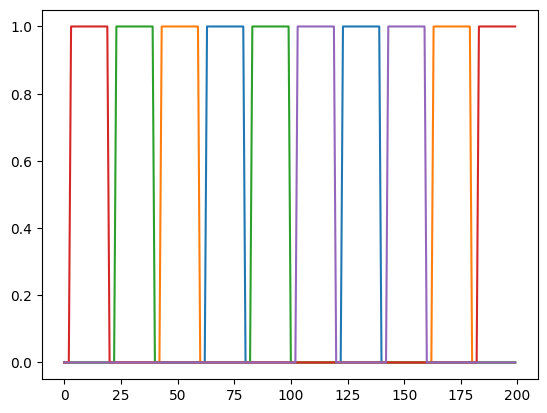



In the above plot, each color represents one of the different tasks, 1 if it's being done, 0 otherwise.
This plot is just one run for one subject, but a similar one is generated for each run of each subject.
The task order is randomized between runs and subjects.


Simulating BOLD data.


Note: There are _many_ parameters involved in setting the kinds and levels of noise,
as well as the degree of correlation (and anti-correlation) between region regions.
I explain above the general principles I used to set these parameters, but the biggest
was just setting them so that the decoder returned a reasonable prediction accuracy (about 90%),
and didn't either sit and chance (50%) or stay pegged at 100%.


These settings do look like reasonable BOLD signals for brain regions -- the BOLD signal roughly
resembles the HCP data. Feel free to play with them and see what you get.


Step 1: Generate baseline BOLD noise and drift for each subject.


Mean drift slope: 0.05
Subject drift variation (SD

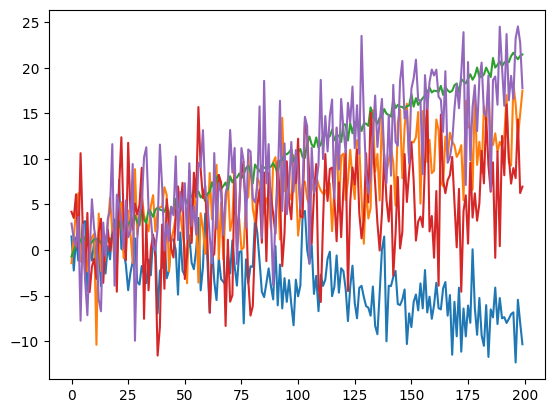



We can zoom out to see it on the scale of the end activity we'll simulate:




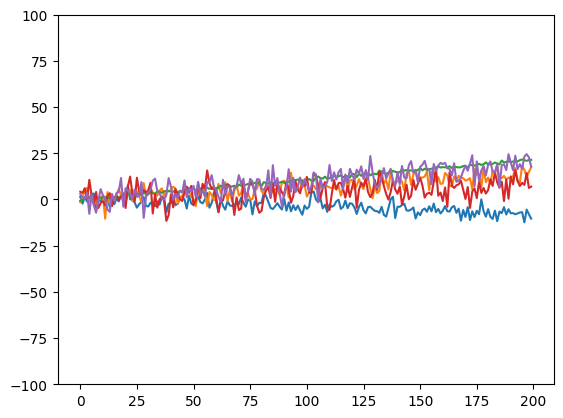



Step 2: Generate random-walk mind-wandering for each subject.


Mean distraction: 2.0
Distraction variation: 1.0


Here is the random-walk mind-wandering added to the baseline noise and drift (in one region,
 the same as before) for the same five subjects, from the same run:




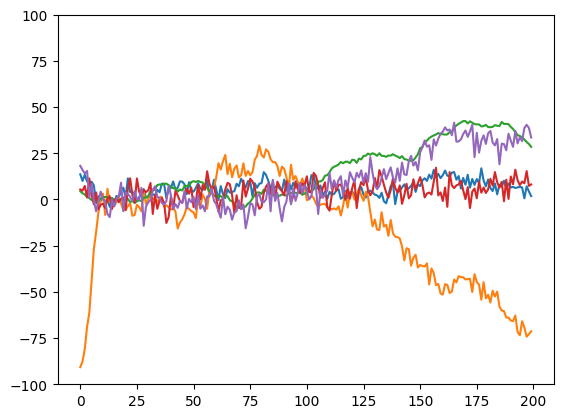



Step 3: Generate activity-driven BOLD signal for each subject.


Constructing HRF convolution amplitude array with bilateral anticorrelation and lateral correlation.


Mean convolution amplitude magnetude: 25.0
Size of variation in amplitude correlation (intrahemisphere): 20.0
Mean anticorrelation noise (interhemisphere): 0
Anticorrelation noise variation (interhemisphere): 3
Convolution amplitude noise: 25
Convolution amplitude jitter: 0.3
Receptive field destabilization factor: 0.9


Setting activity-driven BOLD signal for each subject.


Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%


Example plots of some of the data we just generated:


Activity-driven BOLD signal from one run, in one region (one task, one subject):




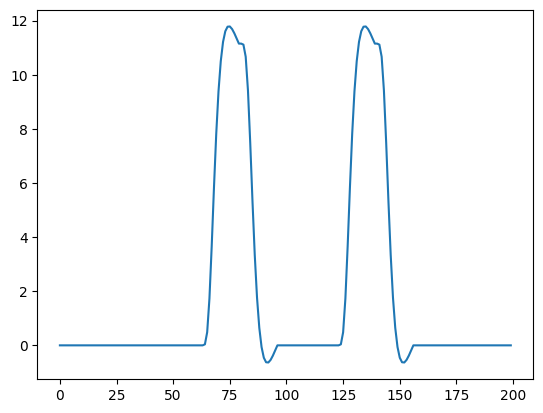



Activity-driven BOLD signal in 3 right regions (same subject) during one right task:




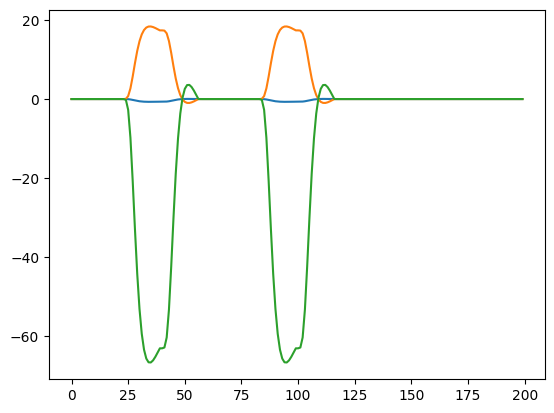



Activity-driven BOLD signal in a left and right region (same subject) during that same right task:




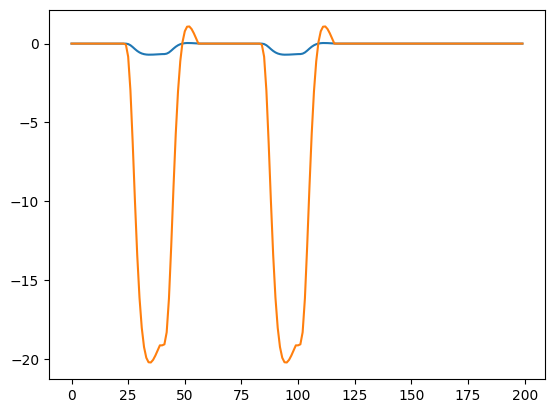



BOLD signal for three different subjects, same region and same run:




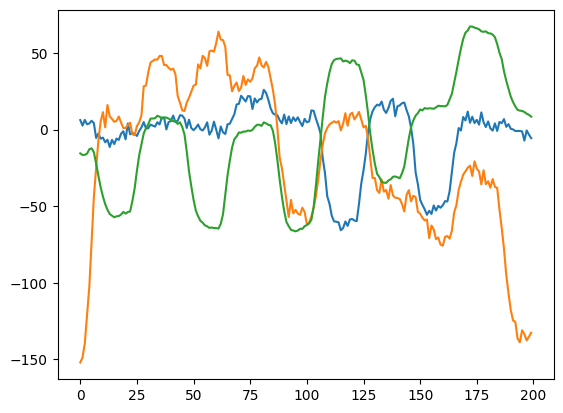



Mean BOLD signal for right-side network in three different subjects, same run:




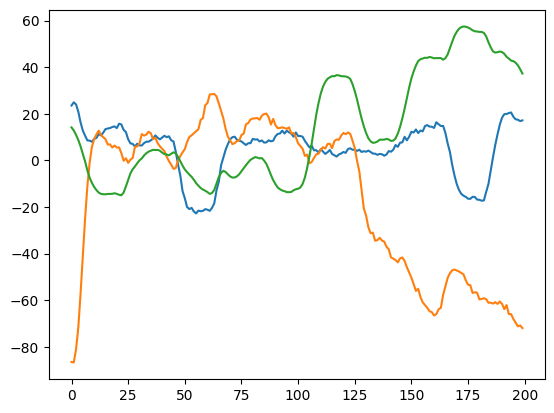

In [32]:
# @title Simulate data (code)

# Packages
#import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt

# To ensure the same data is generated each time (assuming _nothing_ else is changed!).
np.random.seed(100)

print("\n")
print("Simulating task and fMRI time-series data for somatomotor Brodmann regions.")

# Dictionary of somatomotor regions (mostly for visualization with atlas)
# The HCP data from NMA also included 'L_RI': 283, but I've moved so there's symmatry.
somatomotor_regions = {
    'R_4': 7,'R_3b': 8,'R_5m': 35,'R_5L': 38,'R_24dd': 39,'R_24dv': 40,'R_7AL': 41,'R_7PC': 46,'R_1': 50,
    'R_2': 51,'R_3a': 52,'R_6d': 53,'R_6mp': 54,'R_6v': 55,'R_OP4': 99,'R_OP1': 100,'R_OP2-3': 101,'R_FOP2': 114,'R_Ig': 167,
    'L_4': 187,'L_3b': 188,'L_5m': 215,'L_5L': 218,'L_24dd': 219,'L_24dv': 220,'L_7AL': 221,'L_7PC': 226,
    'L_1': 230,'L_2': 231,'L_3a': 232,'L_6d': 233,'L_6mp': 234,'L_6v': 235,'L_OP4': 279,'L_OP1': 280,'L_OP2-3': 281,
    'L_FOP2': 294,'L_Ig': 347
}

# Simulation parameters for faux data
n_subjects = 100
n_regions = len(somatomotor_regions)
tasks = np.array(['lh','lf','rh','rf','t'])
n_tasks = len(tasks)
task_length = 17
cue_length = 3
task_repeats_per_run = 2
run_length = (n_tasks*task_repeats_per_run)*(task_length+cue_length)
n_runs = 2
time_step_size = 0.72 # in seconds

print("\n")
print("Simulation parameters:")

print("\n")
print(f"Number of subjects: {n_subjects}")
print(f"Number of regions: {n_regions}")
print(f"Number of tasks: {n_tasks}")
print(f"Number of runs: {n_runs}")
print(f"Tasks repeats per run: {task_repeats_per_run}")

print("\n")
print(f"Task length: {task_length}")
print(f"Intertask cue length: {cue_length}")
print(f"Run length: {run_length}")

print("\n")
print(f"Tasks: {tasks}")

print("\n")
# Simulate task data
task_data = np.zeros((run_length,n_tasks,n_subjects,n_runs))
for run in np.arange(n_runs):
  for sub in np.arange(n_subjects):
    # Pick a random task order for the subject
    sub_task_order = []
    for task_repeat in np.arange(task_repeats_per_run):
      sub_task_order = sub_task_order + list(range(n_tasks))
    random.shuffle(sub_task_order)
    # Identify task at each step in time series
    task_at_time = []
    for task in sub_task_order:
      for cue_step in np.arange(cue_length):
        task_at_time = task_at_time + [-1]
      for task_step in np.arange(task_length):
        task_at_time = task_at_time + [task]
    if len(task_at_time) != run_length:
      print("Warning! Problem building task_at_time.") # Sanity check
    # Simulate task data for subject
    for time_step in np.arange(run_length):
      for task in np.arange(n_tasks):
        if task == task_at_time[time_step]:
          # Array is all zeros; a 1 indicates that task is happening
          task_data[time_step,task,sub,run] = 1

# Check and demonstrate what we've done:
print("For each subject, on each run, we get a time series of zeros and ones:")

print("\n")
plt.plot(task_data[:,0,0,0])
plt.plot(task_data[:,1,0,0])
plt.plot(task_data[:,2,0,0])
plt.plot(task_data[:,3,0,0])
plt.plot(task_data[:,4,0,0])
plt.show()

print("\n")
print("In the above plot, each color represents one of the different tasks, 1 if it's being done, 0 otherwise.")
print("This plot is just one run for one subject, but a similar one is generated for each run of each subject.")
print("The task order is randomized between runs and subjects.")

print("\n")
print("Simulating BOLD data.")

print("\n")
print("Note: There are _many_ parameters involved in setting the kinds and levels of noise,")
print("as well as the degree of correlation (and anti-correlation) between region regions.")
print("I explain above the general principles I used to set these parameters, but the biggest")
print("was just setting them so that the decoder returned a reasonable prediction accuracy (about 90%),")
print("and didn't either sit and chance (50%) or stay pegged at 100%.")

print("\n")
print("These settings do look like reasonable BOLD signals for brain regions -- the BOLD signal roughly")
print("resembles the HCP data. Feel free to play with them and see what you get.")

print("\n")
print("Step 1: Generate baseline BOLD noise and drift for each subject.")

# Parameters for BOLD noise and drift
mean_drift_slope = 0.05
subject_drift_variation = 0.05
mean_BOLD_noise = 5
subject_BOLD_noise_variation = 1.5
drift_slope = np.random.normal(mean_drift_slope,subject_drift_variation,size=n_subjects)
noise = np.abs(np.random.normal(mean_BOLD_noise,subject_BOLD_noise_variation,size=n_subjects))

print("\n")
print(f"Mean drift slope: {mean_drift_slope}")
print(f"Subject drift variation (SD): {subject_drift_variation}")
print(f"Mean BOLD baseline noise: {mean_BOLD_noise}")
print(f"Subject BOLD baseline noise variation (SD): {subject_BOLD_noise_variation}")

print("\n")
# Simulate time-series BOLD data
BOLD_data = np.zeros((run_length,n_regions,n_subjects,n_runs))
for sub in np.arange(n_subjects):
  for run in np.arange(n_runs):
    for reg in np.arange(n_regions):
      BOLD_data[:,reg,sub,run] = drift_slope[sub] * np.arange(run_length) + np.random.normal(0,noise[sub],size=run_length)

# Check and demonstrate what we've done:
print("Here is the baseline noise and drift (in one region) for five subjects, from one run:")

print("\n")
plt.plot(BOLD_data[:,0,0,0])
plt.plot(BOLD_data[:,0,1,0])
plt.plot(BOLD_data[:,0,2,0])
plt.plot(BOLD_data[:,0,3,0])
plt.plot(BOLD_data[:,0,4,0])
plt.show()

print("\n")
print("We can zoom out to see it on the scale of the end activity we'll simulate:")

print("\n")
plt.plot(BOLD_data[:,0,0,0])
plt.plot(BOLD_data[:,0,1,0])
plt.plot(BOLD_data[:,0,2,0])
plt.plot(BOLD_data[:,0,3,0])
plt.plot(BOLD_data[:,0,4,0])
plt.ylim(-100, 100)
plt.show()

print("\n")
print("Step 2: Generate random-walk mind-wandering for each subject.")

conv_window = int(task_length * 1) # window size for HRF convolution

# Parameters for Random-Walk Mind-Wandering
mean_distraction = 2.0
distraction_variation = 1.0
distraction = np.abs(np.random.normal(mean_distraction,distraction_variation,size=n_subjects))

print("\n")
print(f"Mean distraction: {mean_distraction}")
print(f"Distraction variation: {distraction_variation}")

for sub in np.arange(n_subjects):
  for run in np.arange(n_runs):
    raw_RWMW = np.zeros(run_length)
    for time_step in np.arange(run_length)[1:]:
      raw_RWMW[time_step] = raw_RWMW[time_step-1] + np.random.normal(0,distraction[sub])
    # Convolve with HRF (hemodynamic response function)
    conv_RWMW = convolve_HRF(raw_RWMW,conv_window,1)
    for reg in np.arange(n_regions):
      BOLD_data[:,reg,sub,run] += conv_RWMW

# Check and demonstrate what we've done:
print("\n")
print("Here is the random-walk mind-wandering added to the baseline noise and drift (in one region,\n the same as before) for the same five subjects, from the same run:")

print("\n")
plt.plot(BOLD_data[:,0,0,0])
plt.plot(BOLD_data[:,0,1,0])
plt.plot(BOLD_data[:,0,2,0])
plt.plot(BOLD_data[:,0,3,0])
plt.plot(BOLD_data[:,0,4,0])
plt.ylim(-100, 100)
plt.show()

print("\n")
print("Step 3: Generate activity-driven BOLD signal for each subject.")

print("\n")
print("Constructing HRF convolution amplitude array with bilateral anticorrelation and lateral correlation.")

# Parameters for activity-driven BOLD signal
conv_amp_magnetude = 25.0
correlated_amp_variation_magnetude = 20.0
mean_anticorr_noise = 0
anticorr_noise_variation = 3

conv_amp = np.random.uniform(-conv_amp_magnetude,conv_amp_magnetude,size=(n_tasks,n_regions,n_subjects)) # Gives response of each region to each task, for each subject
conv_amp_noise = 25
conv_amp_jitter = 0.3 # a percentage between 0 and 1.

RF_destabilization = 0.9 # a percentage between 0 and 1.

print("\n")
print(f"Mean convolution amplitude magnetude: {conv_amp_magnetude}")
print(f"Size of variation in amplitude correlation (intrahemisphere): {correlated_amp_variation_magnetude}")
print(f"Mean anticorrelation noise (interhemisphere): {mean_anticorr_noise}")
print(f"Anticorrelation noise variation (interhemisphere): {anticorr_noise_variation}")

print(f"Convolution amplitude noise: {conv_amp_noise}")
print(f"Convolution amplitude jitter: {conv_amp_jitter}")
print(f"Receptive field destabilization factor: {RF_destabilization}")

# Fill convolution amplitude array
'''
We want
- unilateral regions to be correlated by laterality
- bilateral regions to be anticorrelated by laterality
- each region to have a preferred task

This should lead to:
- task-dependent functional connectivity for laterality
- but no task-dependent functional connectivity for extremities
'''
left_tasks = np.array([0,1])
right_tasks = np.array([2,3])
n_regions2 = int(n_regions / 2)
left_regions = np.arange(n_regions2,n_regions)
right_regions = np.arange(n_regions2)
# Correlate unilateral regions by laterality, ensuring at least some regions consistently have task preference across subjects
for task in left_tasks:
  # mean_amp essentially becomes the average response of a given region to a task, across the whole population
  # ... it thereby essentially gives that region a set of consistent preferences, e.g. turning it into a "lh" detector
  # ... so, it's akin to setting up a receptive field for the region
  mean_amp = np.random.uniform(-conv_amp_magnetude,conv_amp_magnetude)
  amp_variation = np.random.uniform(0.1,correlated_amp_variation_magnetude)
  for sub in np.arange(n_subjects):
    conv_amp[task,left_regions,sub] = np.random.normal(mean_amp,amp_variation,size=len(left_regions))
    # This step keeps there from being too much information in each region
    # ... we need to stabilize the receptive fields, so there isn't too much information in them.
    for task_ in left_tasks:
      conv_amp[task_,left_regions,sub] = np.random.normal(conv_amp[task_,left_regions,sub],amp_variation*RF_destabilization,size=conv_amp[task_,left_regions,sub].shape)
for task in right_tasks:
  mean_amp = np.random.uniform(-conv_amp_magnetude,conv_amp_magnetude)
  amp_variation = np.random.uniform(0.1,correlated_amp_variation_magnetude)
  for sub in np.arange(n_subjects):
    conv_amp[task,right_regions,sub] = np.random.normal(mean_amp,amp_variation,size=len(right_regions))
    # This step keeps there from being too much information in each region
    for task_ in right_tasks:
      conv_amp[task_,right_regions,sub] = np.random.normal(conv_amp[task_,right_regions,sub],amp_variation*RF_destabilization,size=conv_amp[task_,right_regions,sub].shape)
# Anticorrelate bilateral regions by laterality
for task in left_tasks:
  for reg in left_regions:
    for sub in np.arange(n_subjects):
      conv_amp[task,reg-n_regions2,sub] = -conv_amp[task,reg,sub] + np.random.normal(mean_anticorr_noise,anticorr_noise_variation)
for task in right_tasks:
  for reg in right_regions:
    for sub in np.arange(n_subjects):
      conv_amp[task,reg+n_regions2,sub] = -conv_amp[task,reg,sub] + np.random.normal(mean_anticorr_noise,anticorr_noise_variation)
# Add noise and jitter convolution amplitude array
conv_amp = np.random.normal(conv_amp,conv_amp_noise,size=conv_amp.shape)
task_jitter = np.random.choice(np.arange(n_tasks), size=int(n_tasks*conv_amp_jitter), replace=False)
region_jitter = np.random.choice(np.arange(n_regions), size=int(n_regions*conv_amp_jitter), replace=False)
subject_jitter = np.random.choice(np.arange(n_subjects), size=int(n_subjects*conv_amp_jitter), replace=False)
task_jitter_shuff = np.random.permutation(task_jitter)
region_jitter_shuff = np.random.permutation(region_jitter)
subject_jitter_shuff = np.random.permutation(subject_jitter)
conv_amp[task_jitter_shuff,:,:] = conv_amp[task_jitter,:,:]
conv_amp[:,region_jitter_shuff,:] = conv_amp[:,region_jitter,:]
conv_amp[:,:,subject_jitter_shuff] = conv_amp[:,:,subject_jitter]

print("\n")
print("Setting activity-driven BOLD signal for each subject.")

print("\n")
# Simulate time-series BOLD data
progress_interval = n_subjects // 10
AD_BOLD_data = np.zeros((run_length,n_regions,n_tasks,n_subjects,n_runs))
for i, sub in enumerate(np.arange(n_subjects)):
  percent_complete = (i + 1) / n_subjects * 100
  if (i + 1) % progress_interval == 0:
      print(f"Progress: {percent_complete:.0f}%")
  for run in np.arange(n_runs):
    for reg in np.arange(n_regions):
      for task in np.arange(n_tasks):
        # First load task time series, which is a string of 1s and 0s.
        raw_task_time_series = task_data[:,task,sub,run]
        # Convolve with HRF (hemodynamic response function)
        conv_task_time_series = convolve_HRF(raw_task_time_series,conv_window,conv_amp[task,reg,sub])
        # Save to AD_BOLD_data array
        AD_BOLD_data[:,reg,task,sub,run] = conv_task_time_series

print("\n")
print("Example plots of some of the data we just generated:")

print("\n")
print("Activity-driven BOLD signal from one run, in one region (one task, one subject):")
print("\n")
plt.plot(AD_BOLD_data[:,0,0,0,0])
plt.show()

# Activity in 3 right regions (same subject) during one right task
print("\n")
print("Activity-driven BOLD signal in 3 right regions (same subject) during one right task:")
print("\n")
plt.plot(AD_BOLD_data[:,0,2,0,0])
plt.plot(AD_BOLD_data[:,1,2,0,0])
plt.plot(AD_BOLD_data[:,2,2,0,0])
plt.show()

# Activity in a left and right region (same subject) during that same right task
print("\n")
print("Activity-driven BOLD signal in a left and right region (same subject) during that same right task:")
print("\n")
plt.plot(AD_BOLD_data[:,0,2,0,0])
plt.plot(AD_BOLD_data[:,n_regions2,2,0,0])
plt.show()

# Sum these AD signals with the baseline noise/drift
for sub in np.arange(n_subjects):
  for run in np.arange(n_runs):
    for reg in np.arange(n_regions):
      BOLD_data[:, reg, sub, run] += np.sum(AD_BOLD_data[:, reg, :, sub, run], axis=1)

print("\n")
print("BOLD signal for three different subjects, same region and same run:")
print("\n")
plt.plot(BOLD_data[:,0,0,0])
plt.plot(BOLD_data[:,0,1,0])
plt.plot(BOLD_data[:,0,2,0])
plt.show()

# Examine mean right-side network activity for three subjects
sub0_mean_network_BOLD = np.mean(BOLD_data[:,:n_regions2,0,0],axis=1)
sub1_mean_network_BOLD = np.mean(BOLD_data[:,:n_regions2,1,0],axis=1)
sub2_mean_network_BOLD = np.mean(BOLD_data[:,:n_regions2,2,0],axis=1)

# We set things up so that convolutional amplitude was correlated across subjects,
# so these should look similar.
print("\n")
print("Mean BOLD signal for right-side network in three different subjects, same run:")
print("\n")
plt.plot(sub0_mean_network_BOLD)
plt.plot(sub1_mean_network_BOLD)
plt.plot(sub2_mean_network_BOLD)
plt.show()

## Data structure

Note that simulated BOLD data is in the array BOLD_data, with axeses:
* sample (time)
* region
* subject
* run

The value of this array at a point is a simulated BOLD reading.

The simulated task data is in the array task_data, with axeses:
* sample (time)
* task
* subject
* run

The value of this array at a point is a 1 if the specified task was being done by the subject on that run at that sample, and 0 otherwise.

# Preliminary Example: Time-Series by Region

Before doing the decoding, let's run through a preliminary example to understand the structure of the data set. (Do not need to run to do the decoding.) Here we plot activity over time for a single brain region in a single subject. Note that vertical colored stripes mark the times of a given task or cue.

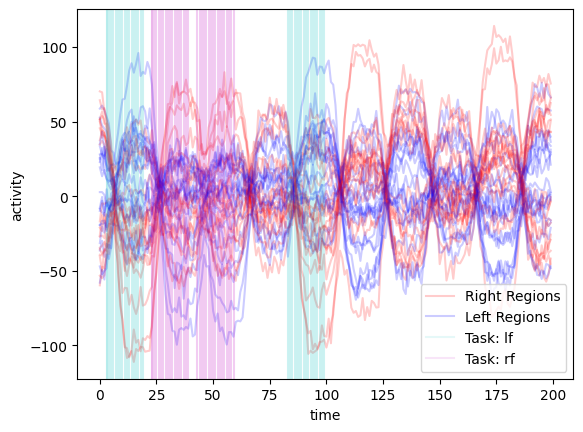



Above we plot, for one subject, the activity in every region, color-coded by hemisphere.
Notice that we should see (in a given subject) a good amount of correlation between region
from the same side, and likewise anticorrelation between regions in different hemispheres.
We programmed this behavior into the simulation (and a lot of noise), and so we do roughly see it.
At least, this should be the case when we have a task with laterality (and 4 of our 5 tasks do).


Now let's look at the same data, but put through a band-pass filter with standard cutoffs for fMRI:




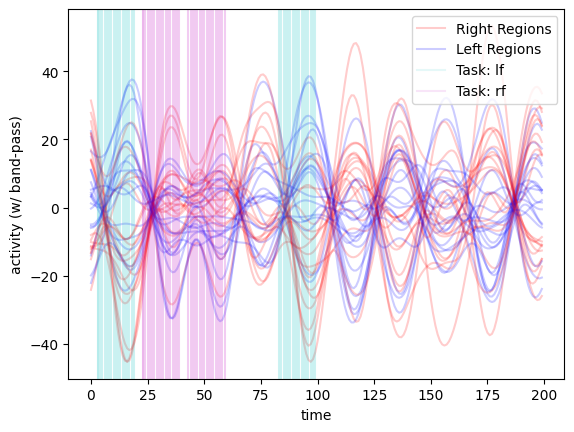

In [33]:
# @title Time-Series by Region

my_subj = 3
my_run = 0

n_regions_to_plot = n_regions2
alphavalue = 0.2

# Let's plot BOLD value from two regions over the entire timecourse
right_region_timeseries = np.copy(BOLD_data[:,:n_regions_to_plot,my_subj,my_run])
left_region_timeseries = np.copy(BOLD_data[:,n_regions2:n_regions2+n_regions_to_plot,my_subj,my_run])

# Now let's grab all the frames of some stimulus condition so we can plot as vertical lines
cond1 = "lf" # which conditions?
cond2 = "rf"
st_fr1 = stim_frames(task_data, my_subj, my_run, cond1)
st_fr2 = stim_frames(task_data, my_subj, my_run, cond2)

# Plot
plt.plot(right_region_timeseries[:,0],color='r',alpha=alphavalue,label=f'Right Regions')
plt.plot(left_region_timeseries[:,0],color='b',alpha=alphavalue,label=f'Left Regions')
for r in np.arange(n_regions_to_plot)[1:]:
  plt.plot(right_region_timeseries[:,r],color='r',alpha=alphavalue)
  plt.plot(left_region_timeseries[:,r],color='b',alpha=alphavalue)
plt.axvline(x=st_fr1[0],color="c",alpha=0.1,label=f'Task: {cond1}')
for st in st_fr1:
  plt.axvline(x=st,color="c",alpha=0.2)
plt.axvline(x=st_fr2[0],color="m",alpha=0.1,label=f'Task: {cond2}')
for st in st_fr2:
  plt.axvline(x=st,color="m",alpha=0.2)
plt.xlabel('time')
plt.ylabel('activity')
plt.legend()
plt.show()

print("\n")
print("Above we plot, for one subject, the activity in every region, color-coded by hemisphere.")
print("Notice that we should see (in a given subject) a good amount of correlation between region")
print("from the same side, and likewise anticorrelation between regions in different hemispheres.")
print("We programmed this behavior into the simulation (and a lot of noise), and so we do roughly see it.")
print("At least, this should be the case when we have a task with laterality (and 4 of our 5 tasks do).")

print("\n")
print("Now let's look at the same data, but put through a band-pass filter with standard cutoffs for fMRI:")
print("\n")

for r in np.arange(n_regions_to_plot):
  right_region_timeseries[:,r] = band_pass(right_region_timeseries[:,r])
  left_region_timeseries[:,r] = band_pass(left_region_timeseries[:,r])

# Plot
plt.plot(right_region_timeseries[:,0],color='r',alpha=alphavalue,label=f'Right Regions')
plt.plot(left_region_timeseries[:,0],color='b',alpha=alphavalue,label=f'Left Regions')
for r in np.arange(n_regions_to_plot)[1:]:
  plt.plot(right_region_timeseries[:,r],color='r',alpha=alphavalue)
  plt.plot(left_region_timeseries[:,r],color='b',alpha=alphavalue)
plt.axvline(x=st_fr1[0],color="c",alpha=0.1,label=f'Task: {cond1}')
for st in st_fr1:
  plt.axvline(x=st,color="c",alpha=0.2)
plt.axvline(x=st_fr2[0],color="m",alpha=0.1,label=f'Task: {cond2}')
for st in st_fr2:
  plt.axvline(x=st,color="m",alpha=0.2)
plt.xlabel('time')
plt.ylabel('activity (w/ band-pass)')
plt.legend()
plt.show()

# GLM Correlation: Prelim Example

The below code is a test run for the GLM analysis we want to run. It walks through the nuts and bolts of a specific case, and allows us to set the beta parameter for L2 regularization.

Beta should be fine now. There are a few variables that can be changed to get / try out different results:

1. r1 and r2: Try out different regions.
2. subject_vector: Change the subject number, or put in multiple subjects to see what happens when we average over them all.
3. training_run, test_run: Which of the two runs (0, 1) should be used as training vs test?
4. l_side, r_side, l_extremity, u_extremity: These are the constant values given to represent the affect (to be scaled by model weight, and the HRF convolution) of lateral (left vs right) and extremity (lower vs upper) position. These are arbitrary, but do have physical meaning. E.g., we should get different results, and the model will have a different physical interpretation, if we set both l_side and r_side to 1, instead of having one as 1 and the other as -1.
5. remove_EL, remove_last_corr, remove_intercept, remove_activity: What inputs should be used for the model? That is, we're trying to predict functional connectivity as a function of some other variables. The main two, from this data, are the activity levels of r1 and r2. What else should we include? We can also include: extremity and lateral location ("EL"), the "last correlation", i.e., the correlation value at 17 time frames before the current correlation being predicted, and the (constant) intercept, i.e. the mean correlation (or activity) value of the whole run. Setting any of the above four variables to False takes out the named inputs from the model.
6. predict_corr: This is the most important thing to change. How are we interpreting "functional connectivity"? If predict_corr = True, we're interpreting it as Pearson correlation calculated over a rolling window of 17 frames (17 frames being the length of each task). It turns out that the model is a terrible fit when we do this. When setting predict_corr = False, the model instead tries to predict the activity of r1 as a function of the activity of r2, plus whatever other variables (e.g., extremity and lateral position) are included. The model does much better this way.



Create GLM to model functional connectivity between two regions.


Model set to predict one region's activity from another's, plus other inputs.


Normalize data: True
Convolve extremity and laterality position: True


Regions to be modelled: R_4, L_4


Subject vector: [0] (what subject are we modelling?)


Beta value for regularization: 1000


Laterality constants: -1 (left), 1 (right)
Extremity constants: -1 (lower/foot), 1 (upper/hand)
HRF convolution amplitude: 10


Model inputs: [1 2 3]
Model input names: ['intercept', 'r2_activity', 'extremity', 'lateral']


Building training data.


Building data (y, X) for:
Region 1: R_4, Atlas num: 7
Region 2: L_4, Atlas num: 187
Training data shape:
y: (183, 1)
X: (183, 3)


Computing theta for linear model with L2 Ridge regularization
thetas: [[-0.19745839]
 [ 0.9453155 ]
 [ 2.5923554 ]
 [ 2.49279885]]




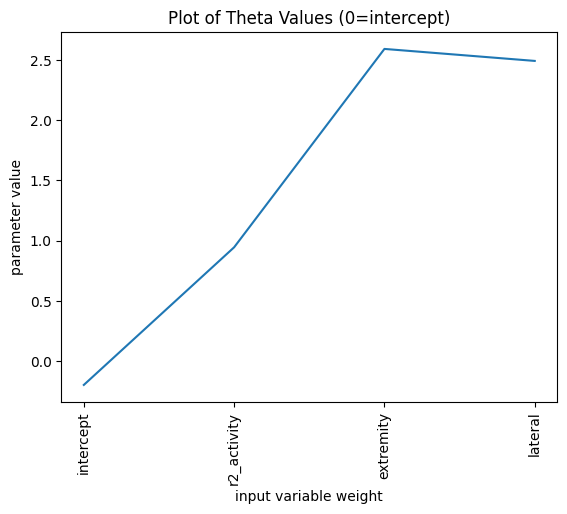



Modelling training data w/ thetas...


Running k-fold cross-validation.




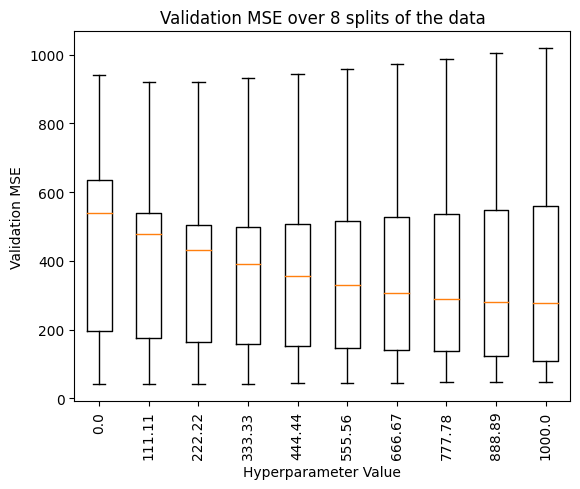



Printing training data y vs modelled y.




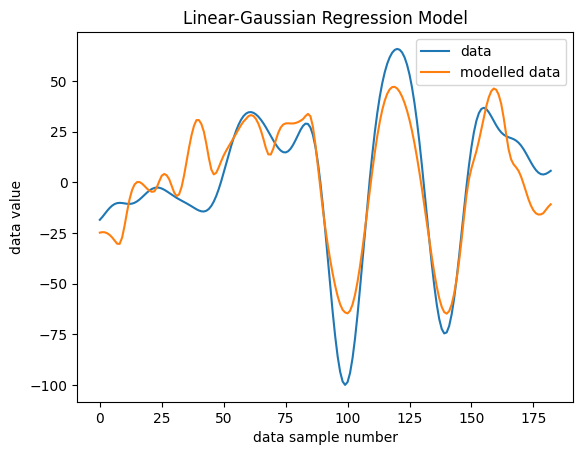



Building test data.


Building data (y, X) for:
Region 1: R_4, Atlas num: 7
Region 2: L_4, Atlas num: 187
Test data shape:
y: (183, 1)
X: (183, 3)


Modelling test data w/ thetas...


Model fit / accuracy:
MSE test: 585.0085014052297
MSE training: 235.26748094114407




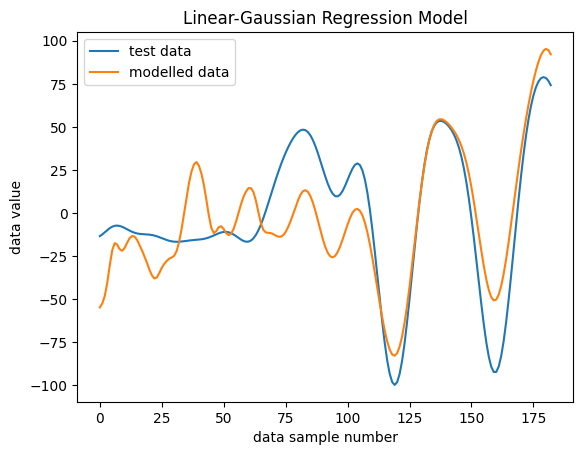

In [40]:
# @title GLM Correlation between Regions in Somatomotor Network

print("\n")
print("Create GLM to model functional connectivity between two regions.")

import matplotlib.ticker as ticker
from scipy.stats import pearsonr
from google.colab import files

# Are we predicting correlation (between r1 and r2), or activity (of r1)?
predict_corr = False
default_window = 17 # length of tasks is 12 sec = 17 frames (720ms/frame)

print("\n")
if predict_corr:
  print(f"Model set to predict Pearson Correlation over a moving window of size {default_window} samples.")
else:
  print("Model set to predict one region's activity from another's, plus other inputs.")

# Subject data varies a lot by magnetude, so normalizing might be a good idea
'''
Normalizing to a max abs value of 100. Leave, do not change!!
'''
normalize_data = True
convolve_EL = True # convolve extremity and laterial time series with hemodynamic response function

print("\n")
print(f"Normalize data: {normalize_data}")
print(f"Convolve extremity and laterality position: {convolve_EL}")


'''
R_4, 7 # primary motor cortex
R_3a, 52 # primary somatosensory cortex

L_4, 187 # primary motor cortex
L_3a, 232 # primary somatosensory cortex
'''
# What regions will we compare?
r1 = "R_4"
r2 = "L_4"

print("\n")
print(f"Regions to be modelled: {r1}, {r2}")

# Subjects to use as data:
subject_vector = np.array([0])
print("\n")
print(f'Subject vector: {subject_vector} (what subject are we modelling?)')

# How should we divide up test and training runs?
training_run = 0
test_run = 1

# Beta value for regularization
'''
These (0.22 and 1000) were selected already based on the results of the k-fold cross validation.
'''
beta = 0.22
betas = np.linspace(0, 2, 10)
if not predict_corr:
  beta = 1000
  betas = np.linspace(0, 1000, 10)
print("\n")
print(f'Beta value for regularization: {beta}')

# Arbitrary values to use for extremity and lateral inputs
'''
The HRF_conv_amp value is not entirely arbitrary: magntitude matters.
If too small, model is not good, but results seem to be the same,
whether = 10 or = 50.
NB: The current value of 10 works well with normalizing to 100.
The HRF window size is set to the task length
'''
l_side = -1
r_side = 1
l_extremity = -1
u_extremity = 1
HRF_conv_amp = 10
HRF_conv_window = default_window
print("\n")
print(f'Laterality constants: {l_side} (left), {r_side} (right)')
print(f'Extremity constants: {l_extremity} (lower/foot), {u_extremity} (upper/hand)')
print(f'HRF convolution amplitude: {HRF_conv_amp}')

# How much of time series (frames) to print?
first_n = 249 # = one participant (the first's) data

# Select inputs for model
remove_EL = False # take out extremity and lateral?
remove_last_corr = True # take out last_corr? (yes!)
remove_intercept = False
remove_activity = False
inputs, input_variable_list = make_inputs(remove_EL__=remove_EL,
                                          remove_last_corr__=remove_last_corr,
                                          remove_intercept__=remove_intercept,
                                          remove_activity__=remove_activity)
print("\n")
print(f'Model inputs: {inputs}')
print(f'Model input names: {input_variable_list}')
'''
Input numbers:
0: r1_activity
1: r2_activity
2: activity_diff
3: extremity
4: lateral
5: last_corr

Note: if at frame n, last_corr is the rolling correlation at frame n - (rolling window size).
If last_corr is the rolling correlation at frame n-1, the model is basically perfect, because it
just predicts the next correlation as equal to last_corr (all theta go to zero except the theta
for last_corr, which goes to 1). By setting last_corr to the correlation just before the current window,
with window the length of the task, we are, in effect, asking the model to predict the effect of
the task (the other inputs) on the correlation between regions.
'''

# Helper functions
def build_yX(region1,region2,run_,inputs_,sub_vector,window=default_window,noisy_print=True,normalize=False):

  '''
  Default: window = 17, because each task block was 12 sec long, .72 sec per frame
  '''

  # Get region numbers and names
  region1_nm = 1 # dummy values for initalization
  region2_nm = 2 # dummy values for initalization
  region1_nmB = 1 # dummy values for initalization
  region2_nmB = 2 # dummy values for initalization
  region1_name = 'name1' # dummy values for initalization
  region2_name = 'name2' # dummy values for initalization
  network_region_names = np.array(list(somatomotor_regions.keys()))
  network_region_numbers_B = np.array(list(somatomotor_regions.values()))
  network_region_numbers = np.arange(len(network_region_numbers_B))
  if type(region1) == str:
    i = np.where(network_region_names==region1)[0]
    region1_nmB = network_region_numbers_B[i].item()
    region1_nm = network_region_numbers[i]
    region1_name = region1
  else:
    region1_nmB = region1
    i = np.where(network_region_numbers_B==region1)[0]
    region1_name = network_region_names[i].item()
    region1_nm = network_region_numbers[i]
  if type(region2) == str:
    i = np.where(network_region_names==region2)[0]
    region2_nmB = network_region_numbers_B[i].item()
    region2_nm = network_region_numbers[i]
    region2_name = region2
  else:
    region2_nmB = region2
    i = np.where(network_region_numbers_B==region2)[0]
    region2_name = network_region_names[i].item()
    region2_nm = network_region_numbers[i]

  # Build data y, X
  if noisy_print:
    print("\n")
    print("Building data (y, X) for:")
    print(f'Region 1: {region1_name}, Atlas num: {region1_nmB}')
    print(f'Region 2: {region2_name}, Atlas num: {region2_nmB}')

  '''
  Each row in y, X is a frame (time slice).
  y is rolling correlation.
  Columns of X are input variables.
  '''

  X = np.empty((0, 5))
  y = np.empty((0, 1))

  # Build all the rows by running through time series of each subject for given run
  for sub_num in sub_vector:

    # Load time series
    data_s = BOLD_data[:,:,sub_num,run_]
    region_timeseries1 = data_s[:,region1_nm][:,0]
    region_timeseries2 = data_s[:,region2_nm][:,0]
    region_timeseries1 = band_pass(region_timeseries1)
    region_timeseries2 = band_pass(region_timeseries2)

    # Normalize
    if normalize:
      r1m = np.max(np.abs(region_timeseries1))
      r2m = np.max(np.abs(region_timeseries2))
      region_timeseries1 = region_timeseries1/r1m * 100
      region_timeseries2 = region_timeseries2/r2m * 100

    # Load condition information
    lh_fr = stim_frames(task_data, sub_num, run_, "lh")
    rh_fr = stim_frames(task_data, sub_num, run_, "rh")
    lf_fr = stim_frames(task_data, sub_num, run_, "lf")
    rf_fr = stim_frames(task_data, sub_num, run_, "rf")

    # Build and stack rows for subject
    time_series_length = len(region_timeseries1)
    for frame in np.arange(time_series_length)[window:]:

      # Compute rolling correlation and build y
      if predict_corr:
        window1 = region_timeseries1[(frame-window):frame]
        window2 = region_timeseries2[(frame-window):frame]
        r, p_value = pearsonr(window1, window2)
        y = np.vstack((y, r)) # Adding the next frame (column) to y
      else: # else we're predicting r1_activity
        y = np.vstack((y, region_timeseries1[frame]))

      # Build X
      r1_activity = region_timeseries1[frame]
      r2_activity = region_timeseries2[frame]
      extremity = 0 # initalizing with arbitrary value
      lateral = 0 # initalizing with arbitrary value
      if ( np.isin(frame, lh_fr) or np.isin(frame, lf_fr) ):
        lateral = l_side
      elif ( np.isin(frame, rh_fr) or np.isin(frame, rf_fr) ):
        lateral = r_side
      if ( np.isin(frame, lh_fr) or np.isin(frame, rh_fr) ):
        extremity = u_extremity
      elif ( np.isin(frame, lf_fr) or np.isin(frame, rf_fr) ):
        extremity = l_extremity
      last_frame = 0
      if (frame>2*window):
        last_frame = (frame-window)-window
      last_corr = y[last_frame,0]
      X_row = np.array([r1_activity,r2_activity,extremity,lateral,last_corr])
      X = np.vstack((X, X_row)) # Adding the next frame (column) to y

  # convolve lateral and last_corr w/ HRF
  if convolve_EL:
    X[:,2] = convolve_HRF(X[:,2],HRF_conv_window,HRF_conv_amp)
    X[:,3] = convolve_HRF(X[:,3],HRF_conv_window,HRF_conv_amp)

  # Keep only requested inputs
  X = X[:,inputs_]

  return y, X

def compute_thetaL2(y,X,b):
  constant = np.ones_like(y)
  X_plus = np.column_stack([constant, X])
  if remove_intercept:
    X_plus = X
  theta_ = np.linalg.inv(X_plus.T @ X_plus + b * np.eye(X_plus.shape[1])) @ X_plus.T @ y
  return theta_

def model_data(y,X,t):
  constant = np.ones_like(y)
  X_plus = np.column_stack([constant, X])
  if remove_intercept:
    X_plus = X
  y_m = X_plus @ t
  return(y_m)

def cross_validate_LinGauss_L2(X_train, y_train, beta_range, n_splits):

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits,len(beta_range)))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(X_train)):

    # Split up the overall training data into cross-validation training and validation sets
    X_cv_train = X_train[train_indices]
    y_cv_train = y_train[train_indices]
    X_cv_val = X_train[val_indices]
    y_cv_val = y_train[val_indices]

    for i_hypers, beta_ in enumerate(beta_range):

      theta_ = compute_thetaL2(y_cv_train,X_cv_train,beta_)
      constant = np.ones_like(y_cv_val)
      X_cv_val_plus = np.column_stack([constant, X_cv_val])
      if remove_intercept:
        X_cv_val_plus = X_cv_val
      y_modelled = X_cv_val_plus @ theta_

      residuals = y_cv_val - y_modelled
      mse_all[i_split,i_hypers] = np.mean(residuals**2)

  return mse_all

def plot_cross_validate_MSE(mse_all,lab):
  """ Plot the MSE values for the K_fold cross validation

  Args:
    mse_all (ndarray): an array of size (number of splits, number of hyperparameters)
  """
  lab = np.round(lab, decimals=2)
  plt.figure()
  plt.boxplot(mse_all, labels=lab)
  plt.xticks(rotation=90)
  plt.xlabel('Hyperparameter Value')
  plt.ylabel('Validation MSE')
  plt.title(f'Validation MSE over {mse_all.shape[0]} splits of the data')
  plt.show()

# Build training data
print("\n")
print("Building training data.")
y_train, X_train = build_yX(r1,r2,training_run,inputs,subject_vector,normalize=normalize_data)
print("Training data shape:")
print(f'y: {y_train.shape}')
print(f'X: {X_train.shape}')

# Get the MLE weights for the Linear-Gaussian model
# L2 Ridge regularization suppresses all weights
print("\n")
print("Computing theta for linear model with L2 Ridge regularization")
theta = compute_thetaL2(y_train,X_train,beta) # theta[0] is bias/intercept
print(f'thetas: {theta}')

# Plot theta values:
print("\n")
plt.plot(np.arange(len(theta)),theta)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xticks(np.arange(len(theta)), input_variable_list, rotation=90)
plt.xlabel('input variable weight')
plt.ylabel('parameter value')
plt.title('Plot of Theta Values (0=intercept)')
plt.show()

# Model training data with theta
print("\n")
print("Modelling training data w/ thetas...")
y_modelled = model_data(y_train,X_train,theta)
residuals_training = y_train - y_modelled
MSE_training = np.mean(residuals_training**2)

# Cross-validate
print("\n")
print("Running k-fold cross-validation.")
from sklearn.model_selection import KFold
import itertools
mse = cross_validate_LinGauss_L2(X_train,y_train,betas,8)
print("\n")
plot_cross_validate_MSE(mse,betas)

print_n = np.minimum(y_train.shape[0],first_n)

print("\n")
print("Printing training data y vs modelled y.")

# Print training y vs modelled y
print("\n")
plt.plot(np.arange(print_n),y_train[:print_n],label="data")
plt.plot(np.arange(print_n),y_modelled[:print_n],label="modelled data")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('data sample number')
plt.ylabel('data value')
plt.title('Linear-Gaussian Regression Model')
plt.legend()
plt.show()

# Build test data
print("\n")
print("Building test data.")
y_test, X_test = build_yX(r1,r2,test_run,inputs,subject_vector,normalize=normalize_data)
print("Test data shape:")
print(f'y: {y_test.shape}')
print(f'X: {X_test.shape}')

# Model test data with theta
print("\n")
print("Modelling test data w/ thetas...")
yt_modelled = model_data(y_test,X_test,theta)
residuals_test = y_test - yt_modelled
MSE_test = np.mean(residuals_test**2)
print("\n")
print("Model fit / accuracy:")
print(f'MSE test: {MSE_test}')
print(f'MSE training: {MSE_training}')

# Print test y vs modelled y
print("\n")
plt.plot(np.arange(print_n),y_test[:print_n],label="test data")
plt.plot(np.arange(print_n),yt_modelled[:print_n],label="modelled data")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('data sample number')
plt.ylabel('data value')
plt.title('Linear-Gaussian Regression Model')
plt.legend()
plt.show()

# GLM Correlation: R2 vs no-EL vs EL+R2 vs EL-only

Let's compare four ways of predicting region 2's activity: By assuming it's the same as R1's activity (R2), using the GLM without extremity-laterality input (no-EL), using the GLM with extremity-laterality input and R2 input (EL+R2), and with only extremity-laterality input (EL-only).



GLM Correlation: EL+R2 vs EL-only vs R2-only


In the above example, the GLM used r2 activity input along with extremity and laterality input.
Are all three really required? Let's look at that same participant again, but now compare
the GLM from above with ones trained on only r2 activity, or only on extremity and laterality input.


Running model with R2 and EL inputs.


Building training data and modelling.


Building data (y, X) for:
Region 1: R_4, Atlas num: 7
Region 2: L_4, Atlas num: 187


Building test data and modelling.


Building data (y, X) for:
Region 1: R_4, Atlas num: 7
Region 2: L_4, Atlas num: 187


Results:
Both EL and R2 inputs: MSE test: 585.0085014052297
Both EL and R2 inputs: MSE training: 235.26748094114407


Running model with out EL inputs (R2 only).


Building training data and modelling.


Building data (y, X) for:
Region 1: R_4, Atlas num: 7
Region 2: L_4, Atlas num: 187


Building test data and modelling.


Building data (y, X) for:
Region 1: R_4, Atlas nu

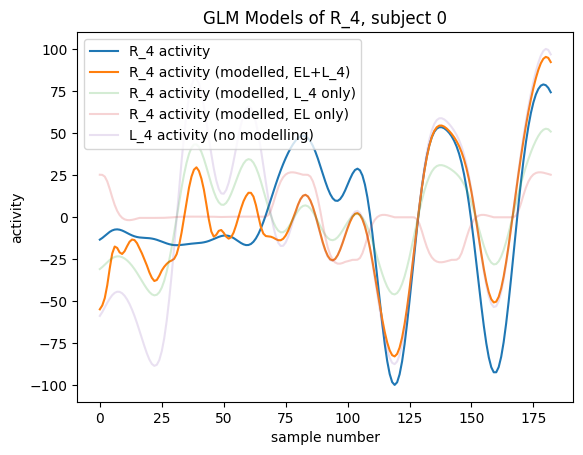

In [47]:
# @title GLM Correlation: EL+R2 vs EL-only vs R2-only

import matplotlib.ticker as ticker
from scipy.stats import pearsonr

print("\n")
print("GLM Correlation: EL+R2 vs EL-only vs R2-only")

print("\n")
print("In the above example, the GLM used r2 activity input along with extremity and laterality input.")
print("Are all three really required? Let's look at that same participant again, but now compare")
print("the GLM from above with ones trained on only r2 activity, or only on extremity and laterality input.")

# Are we predicting correlation (between r1 and r2), or activity (of r1)?
predict_corr = False

# Subject data varies a lot by magnetude, so normalizing might be a good idea
normalize_data = True
convolve_EL = True # convolve extremity and laterial time series with hemodynamic response function

# What regions will we compare?
r1 = "R_4"
r2 = "L_4"

# Subjects to use as data:
sub_numm = 0
subject_vector = np.array([sub_numm])

# Build model with EL and R2 inputs (EL+R2)
remove_EL = False # take out extremity and lateral?
remove_last_corr = True # take out last_corr?
remove_intercept = False
remove_activity = False
inputs, input_variable_list = make_inputs(remove_EL__=remove_EL,
                                          remove_last_corr__=remove_last_corr,
                                          remove_intercept__=remove_intercept,
                                          remove_activity__=remove_activity)

# Run model with EL inputs
print("\n")
print("Running model with R2 and EL inputs.")
print("\n")
print("Building training data and modelling.")
y_train, X_train = build_yX(r1,r2,training_run,inputs,subject_vector,normalize=normalize_data)
theta = compute_thetaL2(y_train,X_train,beta)
y_modelled = model_data(y_train,X_train,theta)
residuals_training = y_train - y_modelled
MSE_training = np.mean(residuals_training**2)
print("\n")
print("Building test data and modelling.")
y_test, X_test = build_yX(r1,r2,test_run,inputs,subject_vector,normalize=normalize_data)
yt_modelled = model_data(y_test,X_test,theta)
residuals_test = y_test - yt_modelled
MSE_test = np.mean(residuals_test**2)
print("\n")
print("Results:")
print(f'Both EL and R2 inputs: MSE test: {MSE_test}')
print(f'Both EL and R2 inputs: MSE training: {MSE_training}')

# Build model with out EL inputs (no-EL)
remove_EL = True # take out extremity and lateral?
remove_last_corr = True # take out last_corr?
remove_intercept = False
remove_activity = False
inputs, input_variable_list = make_inputs(remove_EL__=remove_EL,
                                          remove_last_corr__=remove_last_corr,
                                          remove_intercept__=remove_intercept,
                                          remove_activity__=remove_activity)

# Run model with out EL inputs
print("\n")
print("Running model with out EL inputs (R2 only).")
print("\n")
print("Building training data and modelling.")
y_train, X_train = build_yX(r1,r2,training_run,inputs,subject_vector,normalize=normalize_data)
theta = compute_thetaL2(y_train,X_train,beta)
y_modelled2 = model_data(y_train,X_train,theta)
residuals_training2 = y_train - y_modelled2
MSE_training2 = np.mean(residuals_training2**2)
print("\n")
print("Building test data and modelling.")
y_test, X_test = build_yX(r1,r2,test_run,inputs,subject_vector,normalize=normalize_data)
yt_modelled2 = model_data(y_test,X_test,theta)
residuals_test2 = y_test - yt_modelled2
MSE_test2 = np.mean(residuals_test2**2)
print("\n")
print("Results:")
print(f'no EL inputs: MSE test: {MSE_test2}')
print(f'no EL inputs: MSE training: {MSE_training2}')

# Build model with out R2 inputs (EL-only)
remove_EL = False # take out extremity and lateral?
remove_last_corr = True # take out last_corr?
remove_intercept = False
remove_activity = True
inputs, input_variable_list = make_inputs(remove_EL__=remove_EL,
                                          remove_last_corr__=remove_last_corr,
                                          remove_intercept__=remove_intercept,
                                          remove_activity__=remove_activity)

# Run model with out R2 inputs
print("\n")
print("Running model with out R2 inputs (EL only).")
print("\n")
print("Building training data and modelling.")
y_train, X_train = build_yX(r1,r2,training_run,inputs,subject_vector,normalize=normalize_data)
theta = compute_thetaL2(y_train,X_train,beta)
y_modelled3 = model_data(y_train,X_train,theta)
residuals_training3 = y_train - y_modelled3
MSE_training3 = np.mean(residuals_training3**2)
print("\n")
print("Building test data and modelling.")
y_test, X_test = build_yX(r1,r2,test_run,inputs,subject_vector,normalize=normalize_data)
yt_modelled3 = model_data(y_test,X_test,theta)
residuals_test3 = y_test - yt_modelled3
MSE_test3 = np.mean(residuals_test3**2)
print("\n")
print("Results:")
print(f'only EL inputs: MSE test: {MSE_test3}')
print(f'only EL inputs: MSE training: {MSE_training3}')

# Grab R2 activity time series
print("\n")
print("Grabbing raw R2 activity time series.")
region2_nm_ = 2 # dummy values for initalization
region2_nmB_ = 2 # dummy values for initalization
region2_name_ = 'name2' # dummy values for initalization
network_region_names_ = np.array(list(somatomotor_regions.keys()))
network_region_numbers_B_ = np.array(list(somatomotor_regions.values()))
network_region_numbers_ = np.arange(len(network_region_numbers_B_))
if type(r2) == str:
  i = np.where(network_region_names_==r2)[0]
  region2_nmB_ = network_region_numbers_[i].item()
  region2_nm_ = network_region_numbers_[i]
  region2_name_ = r2
else:
  region2_nmB_ = r2
  i = np.where(network_region_numbers_B_==r2)[0]
  region2_name_ = network_region_names_[i].item()
  region2_nm_ = network_region_numbers_[i]
data_s_ = np.copy(BOLD_data[:,:,sub_numm,test_run])
region_timeseries2_ = data_s_[:,region2_nm_][:,0]
region_timeseries2_ = band_pass(region_timeseries2_)
if normalize_data:
  r2m_ = np.max(np.abs(region_timeseries2_))
  region_timeseries2_ = region_timeseries2_/r2m_ * 100
region_timeseries2_ = region_timeseries2_[default_window:]
residuals_r2 = y_test - region_timeseries2_
MSE_r2 = np.mean(residuals_r2**2)
print(f'R2: MSE: {MSE_r2}')

# Print summary of the important final results
print("\n")
print("Final Results:")
print(f'R2 (no modelling): MSE: {MSE_r2}')
print(f'only EL inputs (no R2): MSE test: {MSE_test3}')
print(f'no EL inputs (only R2): MSE test: {MSE_test2}')
print(f'Both EL and R2 inputs: MSE test: {MSE_test}')

print_n = np.minimum(y_train.shape[0],first_n)

# Print test y vs modelled y
print("\n")
plt.plot(np.arange(print_n),y_test[:print_n],label=f"{r1} activity")
plt.plot(np.arange(print_n),yt_modelled[:print_n],label=f"{r1} activity (modelled, EL+{r2})")
plt.plot(np.arange(print_n),yt_modelled2[:print_n],alpha=0.2,label=f"{r1} activity (modelled, {r2} only)")
plt.plot(np.arange(print_n),yt_modelled3[:print_n],alpha=0.2,label=f"{r1} activity (modelled, EL only)")
plt.plot(np.arange(print_n),region_timeseries2_[:print_n],alpha=0.2,label=f"{r2} activity (no modelling)")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('sample number')
plt.ylabel('activity')
plt.title(f'GLM Models of {r1}, subject {sub_numm}')
plt.legend()
plt.savefig(f'GLM_models_of_{r1}_subject_{sub_numm}.png')
plt.show()

#files.download(f'GLM_models_of_{r1}_subject_{sub_numm}.png')

#GLM Correlation: Population Sampling

The above examples suggest that R_4's activity is better modelled by a GLM which uses L_4's activity plus extremity and laterality information as input, than by a GLM which has only L_4's activity or extremity/laterality information as inputs. However, we just looked at one (simulated) subject. Let's now look at them all and see the distribution.

This chunk of code does the same as the above, except it runs it for all subjects, and stores the MSE (training and test) values for each subject, along with the theta parameters (weights) for the input variables.

In [48]:
# @title Run GLM for entire population

# What regions do we want to test?
r1 = "R_4"
r2 = "L_4"

print("\n")
print(f"Building and evaluating the three kinds of GLM seen above for the entire population")
print(f"of {n_subjects} subjects, for regions r1={r1} and r2={r2}.")

# Make inputs
inputs_EL, input_variable_list_EL = make_inputs(remove_EL__=False,
                                                remove_last_corr__=True,
                                                remove_intercept__=False,
                                                remove_activity__=False)
inputs_nEL, input_variable_list_nEL = make_inputs(remove_EL__=True,
                                                remove_last_corr__=True,
                                                remove_intercept__=False,
                                                remove_activity__=False)
inputs_nR, input_variable_list_nR = make_inputs(remove_EL__=False,
                                                remove_last_corr__=True,
                                                remove_intercept__=False,
                                                remove_activity__=True)

print("\n")
print(f'Inputs EL: {inputs_EL}')
print(f'Input names EL: {input_variable_list_EL}')
print(f'Inputs nEL: {inputs_nEL}')
print(f'Input names nEL: {input_variable_list_nEL}')
print(f'Inputs nR: {inputs_nR}')
print(f'Input names nR: {input_variable_list_nR}')

theta_values_EL = np.zeros((n_subjects,(len(inputs_EL)+1)))
MSE_values_EL = np.zeros((n_subjects,2))
theta_values_nEL = np.zeros((n_subjects,(len(inputs_nEL)+1)))
MSE_values_nEL = np.zeros((n_subjects,2))
theta_values_nR = np.zeros((n_subjects,(len(inputs_nR)+1)))
MSE_values_nR = np.zeros((n_subjects,2))

# Define function to compute the theta values and MSEs for a subject
def model_subject(subject_num,i):
  y_train_s, X_train_s = build_yX(r1,r2,training_run,i,np.array([subject_num]),noisy_print=False,normalize=normalize_data)
  theta_s = compute_thetaL2(y_train_s,X_train_s,beta)
  y_modelled_s = model_data(y_train_s,X_train_s,theta_s)
  residuals_training_s = y_train_s - y_modelled_s
  MSE_training_s = np.mean(residuals_training_s**2)
  y_test_s, X_test_s = build_yX(r1,r2,test_run,i,np.array([subject_num]),noisy_print=False,normalize=normalize_data)
  yt_modelled_s = model_data(y_test_s,X_test_s,theta_s)
  residuals_test_s = y_test_s - yt_modelled_s
  MSE_test_s = np.mean(residuals_test_s**2)
  return MSE_training_s, MSE_test_s, theta_s

# Run through all subjects and compute theta values and MSEs, both with and without extremity and lateral inputs
for this_subject in np.arange(n_subjects):
  o1, o2, o3 = model_subject(this_subject,inputs_EL)
  MSE_values_EL[this_subject,0] = o1
  MSE_values_EL[this_subject,1] = o2
  theta_values_EL[this_subject,:] = o3.T
  no1, no2, no3 = model_subject(this_subject,inputs_nEL)
  MSE_values_nEL[this_subject,0] = no1
  MSE_values_nEL[this_subject,1] = no2
  theta_values_nEL[this_subject,:] = no3.T
  nRo1, nRo2, nRo3 = model_subject(this_subject,inputs_nR)
  MSE_values_nR[this_subject,0] = nRo1
  MSE_values_nR[this_subject,1] = nRo2
  theta_values_nR[this_subject,:] = nRo3.T

Inputs EL: [1 2 3]
Input names EL: ['intercept', 'r2_activity', 'extremity', 'lateral']
Inputs nEL: [1]
Input names nEL: ['intercept', 'r2_activity']
Inputs nR: [2 3]
Input names nR: ['intercept' 'extremity' 'lateral']




Now let's examine the results.


Let's start with boxplots of each input variable weight.


Plot 1: ... for the GLm using all inputs, including extremity and lateral input.




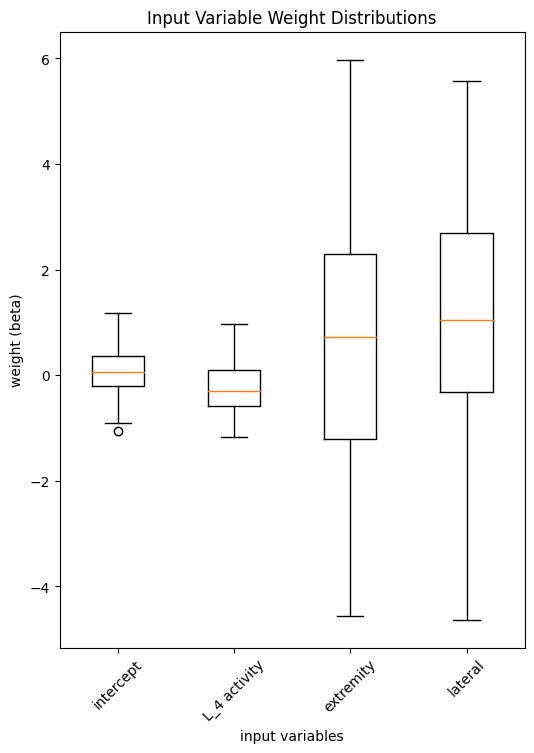



Plot 2: ... for the GLm using just r2, no extremity and lateral input.




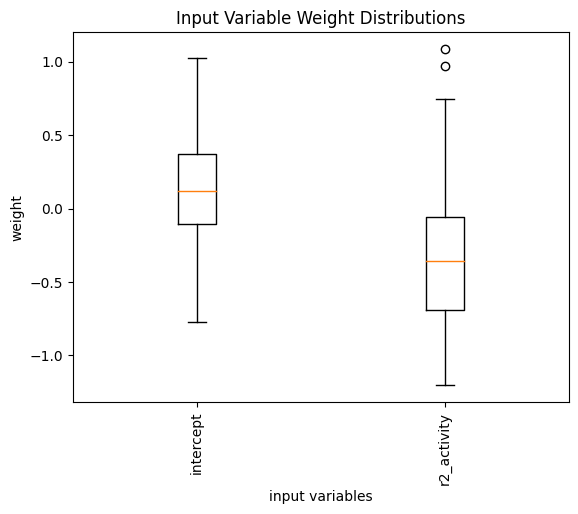



Plot 3: ... for the GLm using just extremity and lateral input, no r2 input.




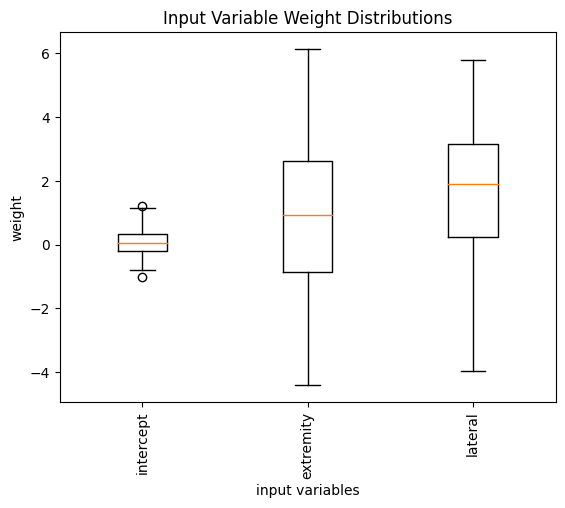



Plot 4: Next we'll plot the distribution of MSE for the three models.




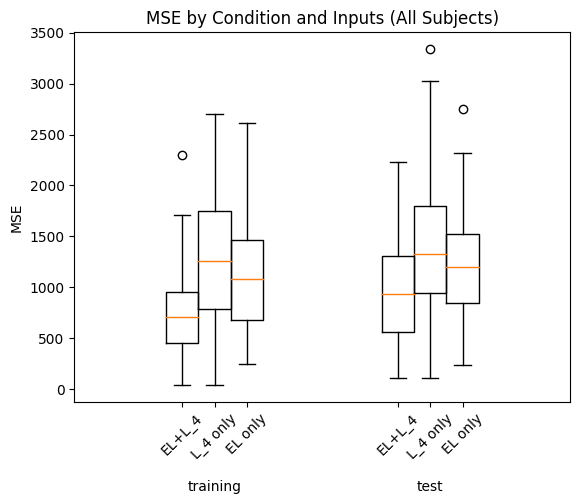



Plot 5: .. we don't really care about the training data, so, plot just the test data.




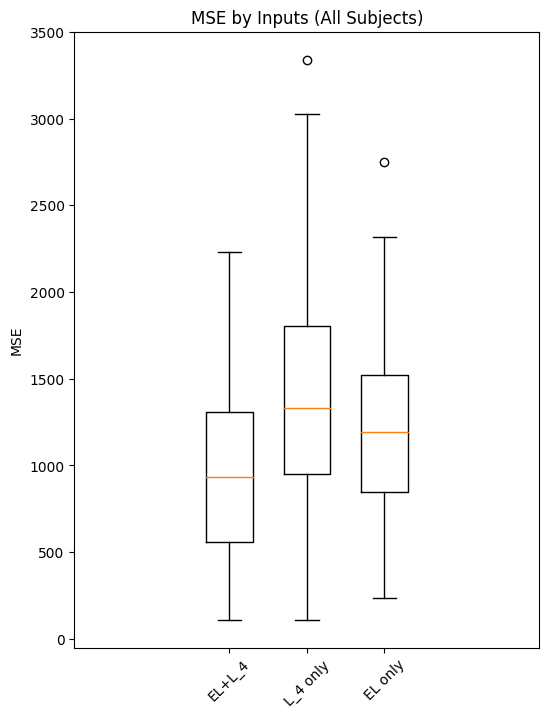



Next, we'll compute change in MSE from EL to nEL as percentage of MSE for nEL.


And, we'll compute change in MSE from EL to nR as percentage of MSE for nR.


Plot 6: ... Now plot this change in MSE.




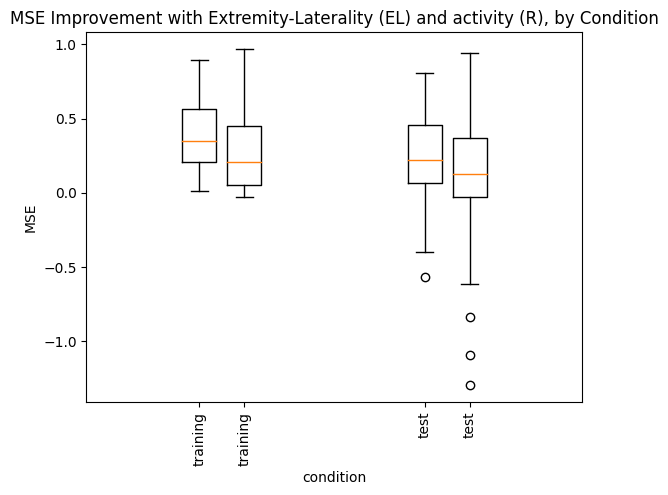



Plot 7: ... Show distributions in histograms.




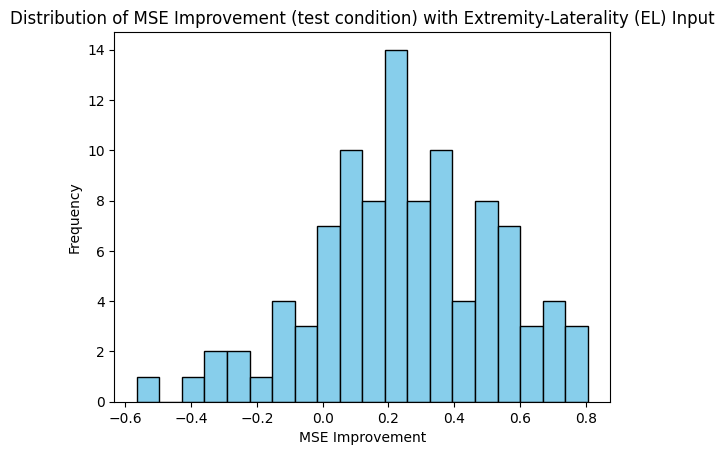



Plot 8:




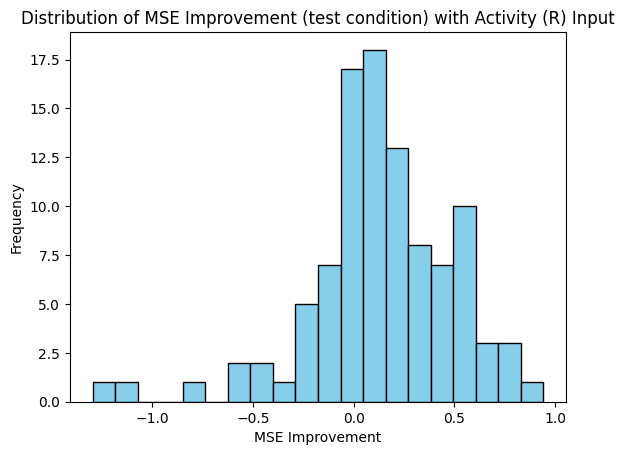



Finally, we'll find the mean of this change (improvement): 


Mean MSE improvement (training, test) with EL+R over noEL, as percentage of MSE without EL: [0.38129596 0.24666809]
Mean MSE improvement (training, test) with EL+R over noR, as percentage of MSE without R: [0.27405485 0.13107835]


In [53]:
# @title Plot distribution

print("\n")
print(f"Now let's examine the results.")

print("\n")
print(f"Let's start with boxplots of each input variable weight.")

# Let's start with boxplots of each input variable weight
# ... for all inputs, including extremity and lateral
print("\n")
print("Plot 1: ... for the GLm using all inputs, including extremity and lateral input.")
print("\n")
input_variable_list_EL_ = input_variable_list_EL
input_variable_list_EL_[1] = f'{r2} activity'
plt.figure(figsize=(6, 8))
plt.boxplot(theta_values_EL, labels=input_variable_list_EL)
plt.xticks(rotation=45)
plt.xlabel('input variables')
plt.ylabel('weight (beta)')
plt.title('Input Variable Weight Distributions')
plt.savefig(f'beta_stats.png')
plt.show()
#files.download(f'beta_stats.png')

print("\n")
print("Plot 2: ... for the GLm using just r2, no extremity and lateral input.")
print("\n")
plt.boxplot(theta_values_nEL, labels=input_variable_list_nEL)
plt.xticks(rotation=90)
plt.xlabel('input variables')
plt.ylabel('weight')
plt.title('Input Variable Weight Distributions')
plt.show()

print("\n")
print("Plot 3: ... for the GLm using just extremity and lateral input, no r2 input.")
print("\n")
plt.boxplot(theta_values_nR, labels=input_variable_list_nR)
plt.xticks(rotation=90)
plt.xlabel('input variables')
plt.ylabel('weight')
plt.title('Input Variable Weight Distributions')
plt.show()

# Plot the MSEs
print("\n")
print(f"Plot 4: Next we'll plot the distribution of MSE for the three models.")
print("\n")
MSE_lab_EL = [f'EL+{r2}', f'EL+{r2}']
MSE_lab_nEL = [f'{r2} only', f'{r2} only']
MSE_lab_nR = [f'EL only', f'EL only']
positions1 = np.arange(1, MSE_values_EL.shape[1] + 1) - 0.15
positions2 = np.arange(1, MSE_values_nEL.shape[1] + 1) + 0.0
positions3 = np.arange(1, MSE_values_nR.shape[1] + 1) + 0.15
plt.boxplot(MSE_values_EL, positions=positions1, labels=MSE_lab_EL)
plt.boxplot(MSE_values_nEL, positions=positions2, labels=MSE_lab_nEL)
plt.boxplot(MSE_values_nR, positions=positions3, labels=MSE_lab_nR)
plt.text(positions2[0], -1000, 'training', ha='center')
plt.text(positions2[1], -1000, 'test', ha='center')
plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.title('MSE by Condition and Inputs (All Subjects)')
plt.savefig(f'MSE_GLM_models.png')
plt.show()
#files.download(f'MSE_GLM_models.png')

# Plot the MSEs, test only
print("\n")
print(f"Plot 5: .. we don't really care about the training data, so, plot just the test data.")
print("\n")
plt.figure(figsize=(6, 8))
plt.boxplot(MSE_values_EL[:,1], positions=[0.25], labels=[f'EL+{r2}'])
plt.boxplot(MSE_values_nEL[:,1], positions=[0.5], labels=[f'{r2} only'])
plt.boxplot(MSE_values_nR[:,1], positions=[0.75], labels=[f'EL only'])
plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.title('MSE by Inputs (All Subjects)')
plt.savefig(f'MSE_GLM_models_testonly.png')
plt.show()
#files.download(f'MSE_GLM_models_testonly.png')

# Compute change in MSE from EL to nEL as percentage of MSE for nEL
print("\n")
print(f"Next, we'll compute change in MSE from EL to nEL as percentage of MSE for nEL.")
print("\n")
MSE_change = np.zeros((n_subjects,2))
for this_subject in np.arange(n_subjects):
  # difference in training MSE (positive is improvement with EL)
  MSE_change[this_subject,0] = (MSE_values_nEL[this_subject,0] - MSE_values_EL[this_subject,0]) / MSE_values_nEL[this_subject,0]
  # difference in test MSE (positive is improvement with EL)
  MSE_change[this_subject,1] = (MSE_values_nEL[this_subject,1] - MSE_values_EL[this_subject,1]) / MSE_values_nEL[this_subject,1]

# Compute change in MSE from EL to nR as percentage of MSE for nR
print(f"And, we'll compute change in MSE from EL to nR as percentage of MSE for nR.")
print("\n")
MSE_changeR = np.zeros((n_subjects,2))
for this_subject in np.arange(n_subjects):
  # difference in training MSE (positive is improvement with R)
  MSE_changeR[this_subject,0] = (MSE_values_nR[this_subject,0] - MSE_values_EL[this_subject,0]) / MSE_values_nR[this_subject,0]
  # difference in test MSE (positive is improvement with R)
  MSE_changeR[this_subject,1] = (MSE_values_nR[this_subject,1] - MSE_values_EL[this_subject,1]) / MSE_values_nR[this_subject,1]

# Plot change in MSE
print(f"Plot 6: ... Now plot this change in MSE.")
print("\n")
MSE_lab = ['training', 'test']
positions1mse = np.arange(1, MSE_values_EL.shape[1] + 1) - 0.1
positions2mse = np.arange(1, MSE_values_nEL.shape[1] + 1) + 0.1
plt.boxplot(MSE_change, positions=positions1mse, labels=MSE_lab)
plt.boxplot(MSE_changeR, positions=positions2mse, labels=MSE_lab)
plt.xticks(rotation=90)
plt.xlabel('condition')
plt.ylabel('MSE')
plt.title('MSE Improvement with Extremity-Laterality (EL) and activity (R), by Condition')
plt.show()

print("\n")
print(f"Plot 7: ... Show distributions in histograms.")
print("\n")
plt.hist(MSE_change[:,1], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of MSE Improvement (test condition) with Extremity-Laterality (EL) Input')
plt.xlabel('MSE Improvement')
plt.ylabel('Frequency')
plt.show()

print("\n")
print(f"Plot 8:")
print("\n")

plt.hist(MSE_changeR[:,1], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of MSE Improvement (test condition) with Activity (R) Input')
plt.xlabel('MSE Improvement')
plt.ylabel('Frequency')
plt.show()

# Find mean improvement:
print("\n")
print(f"Finally, we'll find the mean of this change (improvement): ")
print("\n")
print(f'Mean MSE improvement (training, test) with EL+R over noEL, as percentage of MSE without EL: {MSE_change.mean(axis=0)}')
print(f'Mean MSE improvement (training, test) with EL+R over noR, as percentage of MSE without R: {MSE_changeR.mean(axis=0)}')


# Discussion

* Interestingly, in our simulated data, input about extremity and lateral location are (among the entire population) much more important drivers of R_4 activity, then L_4 activity (plot 1).

* Interestingly, when you take away extremity and lateral information, the model doesn't weight L_4 input any more (plots 1, 2).

* Likewise, the weight of the extremity and laterality inputs doesn't decrease when the L_4 input is removed (plots 1, 3).

* As expected, MSE is, on average (median), lower for the GLM using all inputs, rather than just L_4 input or extremity/laterality input (plots 4, 5). This is also confirmed by the generally positive improvement (in individual subjects) in MSE using all inputs, vs just L_4 or extremity/laterality input (plots 6-8). This improvement, on average (mean), is (for test data) 24.7% when adding extremity/laterality input to L_4 input, and 13.1% when adding L_4 input to extremmity/laterality input.